In [1]:
pip install opencv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [19]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [20]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed 
mean_gray = 0.1307
stddev_gray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

#Load our dataset
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms_ori,
                            download = True)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms_ori)

# Visualizing and loading dataset

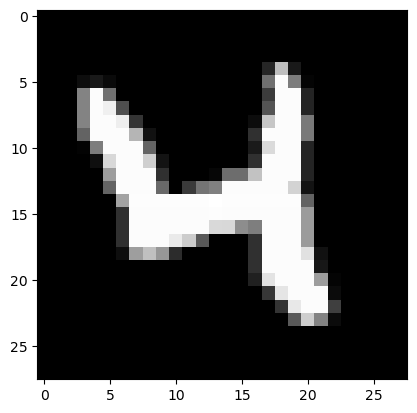

In [21]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [5]:
train_dataset[20][1]

4

In [6]:
batch_size = 100
epochs = 10
#Make the dataset iterable
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

In [7]:
len(train_dataset)

60000

In [8]:
len(train_load)

600

In [9]:
len(test_load)

100

# Building CNN

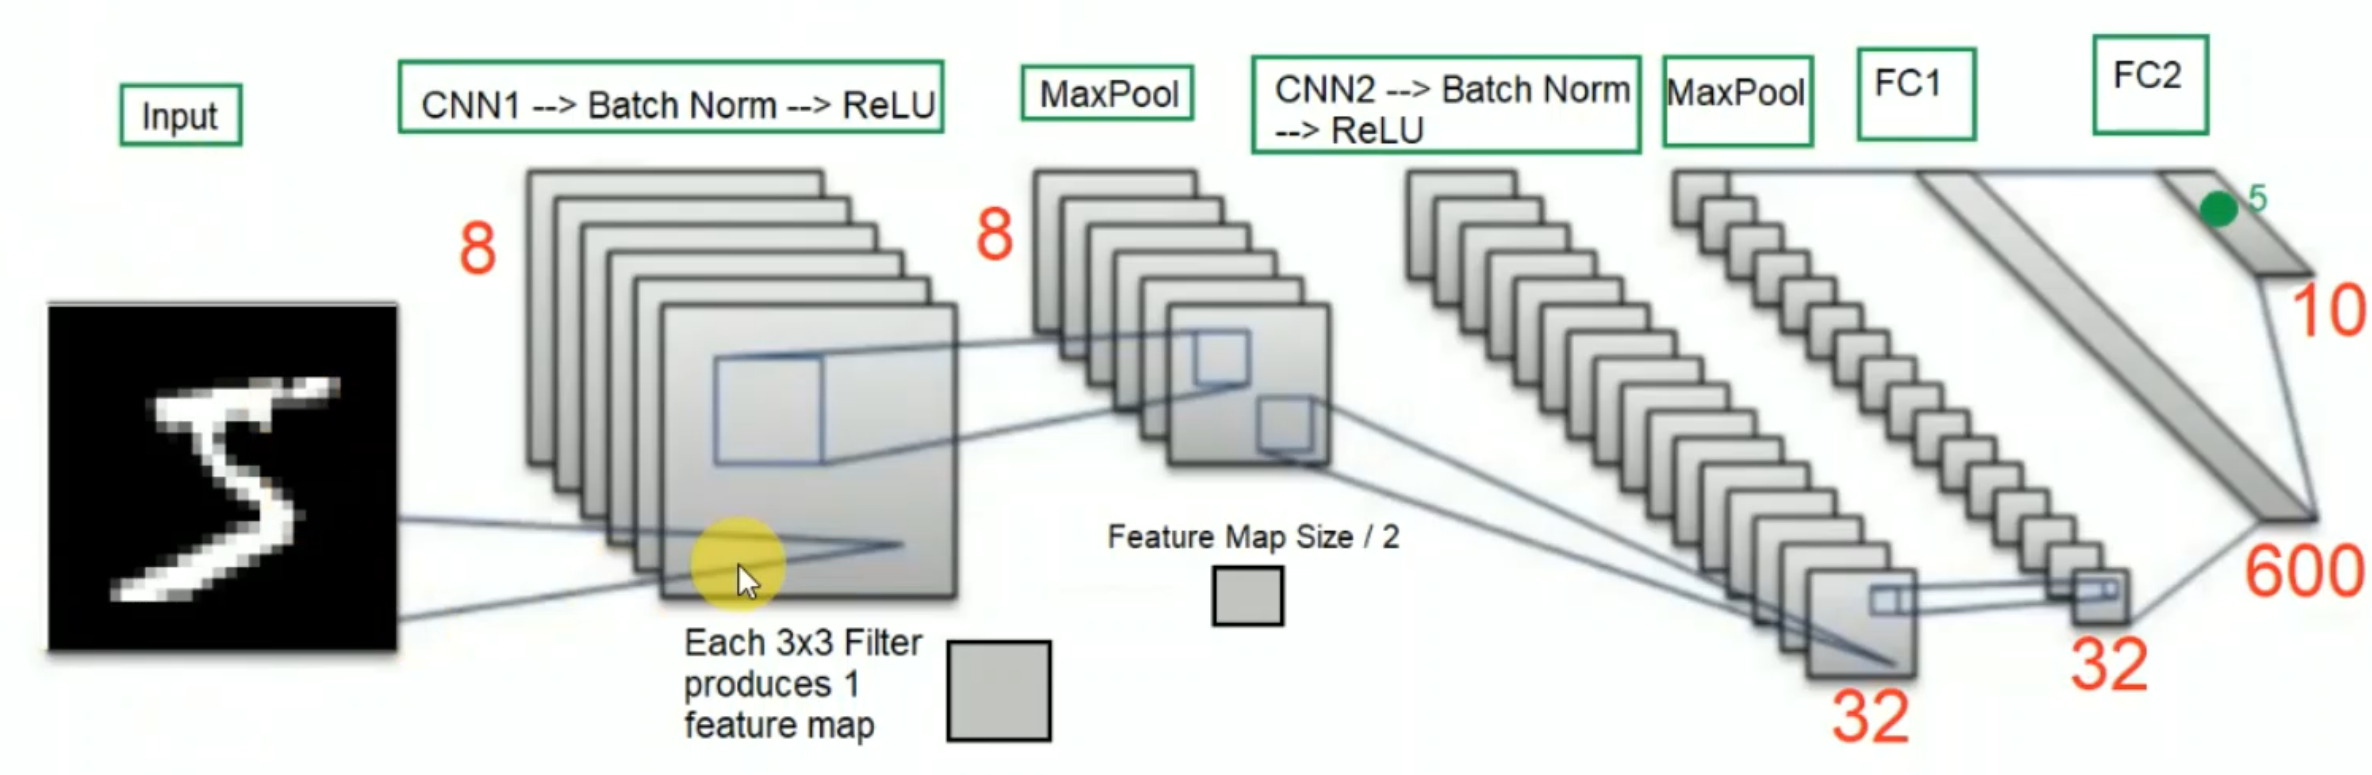

In [10]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

# Defining Model

In [11]:
model=CNN()
CUDA= torch.cuda.is_available()
if CUDA:
    model = model.cuda()
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [12]:
#Understand what's happening
iteration = 0
correct_nodata = 0
correct_data = 0
for i,(inputs,labels) in enumerate (train_load):
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted_nodata = torch.max(output, 1)
    print("Predicted Shape",predicted_nodata.shape)
    print("Predicted Tensor:")
    print(predicted_nodata)
    correct_nodata += (predicted_nodata == labels).sum()
    print("Correct Predictions: ",correct_nodata)
    _, predicted_data = torch.max(output.data, 1)
    correct_data += (predicted_data == labels.data).sum()
    print("Correct Predictions:",correct_data)
    

    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([2, 6, 6, 5, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 6, 6, 4, 2, 4, 4, 6, 6, 4,
        5, 4, 4, 6, 4, 4, 6, 4, 6, 6, 4, 2, 6, 4, 4, 1, 4, 6, 4, 4, 4, 4, 4, 4,
        8, 4, 4, 4, 4, 4, 6, 6, 8, 4, 4, 6, 2, 6, 6, 4, 4, 4, 4, 4, 6, 6, 4, 4,
        4, 4, 4, 4, 6, 4, 5, 4, 2, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 8, 4, 6,
        4, 6, 6, 4])
Correct Predictions:  tensor(16)
Correct Predictions: tensor(16)


# Training CNN

In [13]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data      # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        loss += loss.data
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 1.202, Training Accuracy: 59.175, Testing Loss: 0.004, Testing Acc: 96.220
Epoch 2/10, Training Loss: 0.314, Training Accuracy: 89.565, Testing Loss: 0.000, Testing Acc: 98.140
Epoch 3/10, Training Loss: 0.148, Training Accuracy: 95.485, Testing Loss: 0.000, Testing Acc: 98.530
Epoch 4/10, Training Loss: 0.109, Training Accuracy: 96.798, Testing Loss: 0.000, Testing Acc: 98.950
Epoch 5/10, Training Loss: 0.094, Training Accuracy: 97.273, Testing Loss: 0.000, Testing Acc: 98.700
Epoch 6/10, Training Loss: 0.085, Training Accuracy: 97.532, Testing Loss: 0.000, Testing Acc: 98.790
Epoch 7/10, Training Loss: 0.071, Training Accuracy: 97.855, Testing Loss: 0.000, Testing Acc: 98.810
Epoch 8/10, Training Loss: 0.070, Training Accuracy: 97.955, Testing Loss: 0.000, Testing Acc: 98.960
Epoch 9/10, Training Loss: 0.067, Training Accuracy: 98.050, Testing Loss: 0.000, Testing Acc: 98.930
Epoch 10/10, Training Loss: 0.064, Training Accuracy: 98.108, Testing Loss: 0.000,

# Plotting the Loss

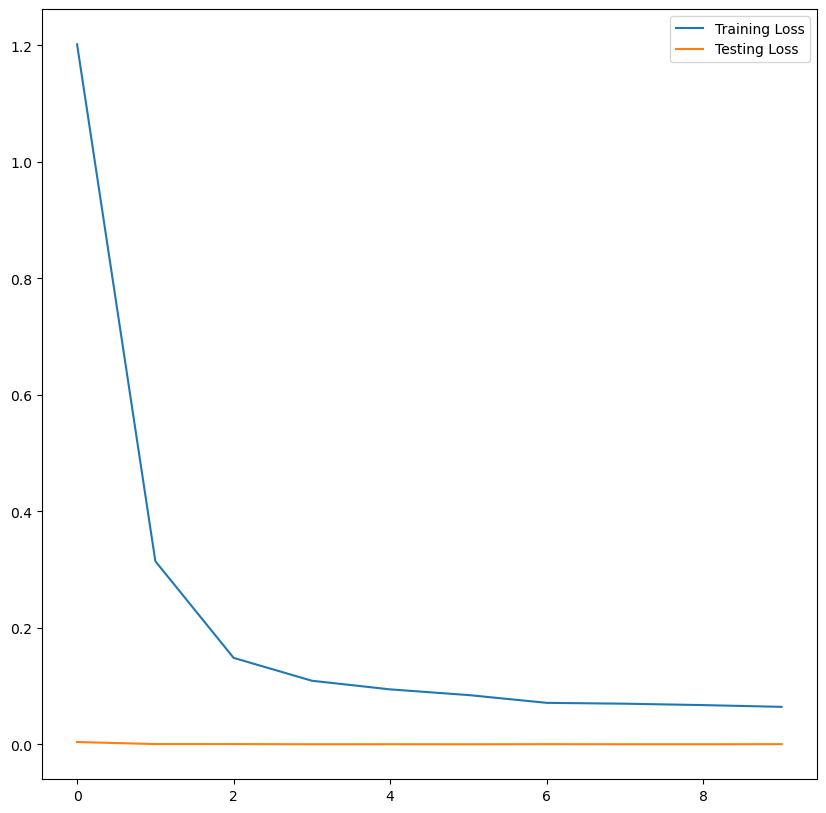

In [22]:
# Loss
f = plt.figure(figsize =(10,10))
plt.plot(train_loss, label = "Training Loss")
t_loss=[fl.item() for fl in test_loss ]
plt.plot(t_loss, label = "Testing Loss")
plt.legend()
plt.show()

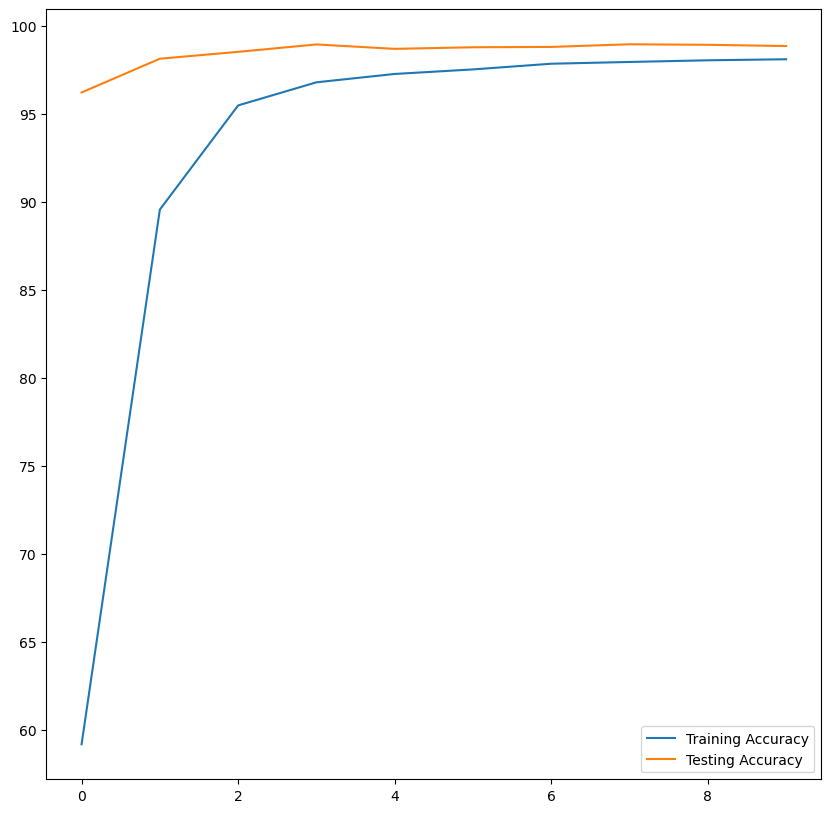

In [23]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [24]:
#Run this if you want to save the model
torch.save(model.state_dict(),'CNN_MNIST.pth')

In [25]:
#Run this if you want to load the model
model.load_state_dict(torch.load('CNN_MNIST.pth'))

<All keys matched successfully>

In [26]:
img = test_dataset[6][0].resize_((1,1,28,28))
label = test_dataset[6][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()
    
outputs = model(img)
_,predicted = torch.max(outputs,1)
print("Prediction is : {}".format(predicted.item()))
print("Actual is : {}".format(label))

Prediction is : 4
Actual is : 4


In [27]:
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name,0)   #Read the image
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = 255-thresholded           #Apply image negative
    cv2.imshow('Original',img)      #Display the processed image
    cv2.waitKey(0)              
    cv2.destroyAllWindows()
    img = Image.fromarray(img)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations 
    img = img.view(1,1,28,28)       #Add batch size 
    img = Variable(img)             #Wrap the tensor to a variable
    
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

In [28]:
pred = predict('pic_num.jpg', model)
print("The Predicted Label is {}".format(pred))

tensor([[ 1.5179, -1.8687, -0.8782, -1.1341, -1.3581, -0.2567, -1.2016, -1.5313,
          1.3170,  0.9935]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5179, -1.8687, -0.8782, -1.1341, -1.3581, -0.2567, -1.2016, -1.5313,
          1.3170,  0.9935]])
The Predicted Label is 0


In [29]:
pred = predict('5.jpg', model)
print("The Predicted Label is {}".format(pred))

tensor([[-4.7043, -1.0812, -6.3733, -1.3959,  0.2004,  4.6029, -1.4957, -3.1382,
         -0.9168,  1.8290]], grad_fn=<AddmmBackward0>)
tensor([[-4.7043, -1.0812, -6.3733, -1.3959,  0.2004,  4.6029, -1.4957, -3.1382,
         -0.9168,  1.8290]])
The Predicted Label is 5


In [30]:
pred = predict('4.jpg', model)
print("The Predicted Label is {}".format(pred))

tensor([[-9.1488,  1.5874, -6.7722, -8.6084, 10.9261, -6.6320,  1.7026, -3.2898,
         -3.3304,  0.5397]], grad_fn=<AddmmBackward0>)
tensor([[-9.1488,  1.5874, -6.7722, -8.6084, 10.9261, -6.6320,  1.7026, -3.2898,
         -3.3304,  0.5397]])
The Predicted Label is 4


In [ ]:
pred = predict('3.jpg', model)
print("The Predicted Label is {}".format(pred))

In [ ]:
pred = predict('9.jpg', model)
print("The Predicted Label is {}".format(pred))

In [31]:
pred = predict('8.jpg', model)
print("The Predicted Label is {}".format(pred))

tensor([[ 0.6704, -1.1445,  0.0076,  0.2702, -1.4228,  0.0129, -0.9584, -1.1198,
          1.6630,  0.3078]], grad_fn=<AddmmBackward0>)
tensor([[ 0.6704, -1.1445,  0.0076,  0.2702, -1.4228,  0.0129, -0.9584, -1.1198,
          1.6630,  0.3078]])
The Predicted Label is 8


In [ ]:
pred = predict('7.jpg', model)
print("The Predicted Label is {}".format(pred))